In [22]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import proplot
from natsort import natsorted
import torch
from tqdm import tqdm
from twaidata.torchdatasets.DirectoryParser3DMRIDataset import *
from trustworthai.journal_run.evaluation.new_scripts.eval_helper_functions import *

In [2]:
wmh_ds = WMHChallengeInterRaterDataset()

In [3]:
xs, ys, ind = wmh_ds[0]

In [4]:
ind

'0'

In [5]:
xs.keys()

dict_keys(['mask', 'FLAIR', 'T1'])

In [6]:
ys.keys()

dict_keys(['wmh', 'wmho3', 'wmho4'])

In [20]:
vol1 = []
vol2 = []
vol3 = []
dice = []
for (xs, ys, ind) in tqdm(wmh_ds):
        wmh1 = ys['wmho3'].cuda()
        wmh2 = ys['wmho4'].cuda()
        wmh3 = ys['wmh'].cuda()
        vol1.append(wmh1.sum().item())
        vol2.append(wmh2.sum().item())
        vol3.append(wmh3.sum().item())
        dice.append((fast_dice(wmh1, wmh2) + fast_dice(wmh1, wmh3) + fast_dice(wmh2, wmh3)) / 3)
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:12<00:00,  4.78it/s]


In [31]:
df = pd.DataFrame({
    "WMH1_mm3":torch.Tensor(vol1) * 0.003,
    "WMH2_mm3":torch.Tensor(vol2) * 0.003,
    "WMH3_mm3":torch.Tensor(vol3) * 0.003,
    "DSC":torch.Tensor(dice)
})

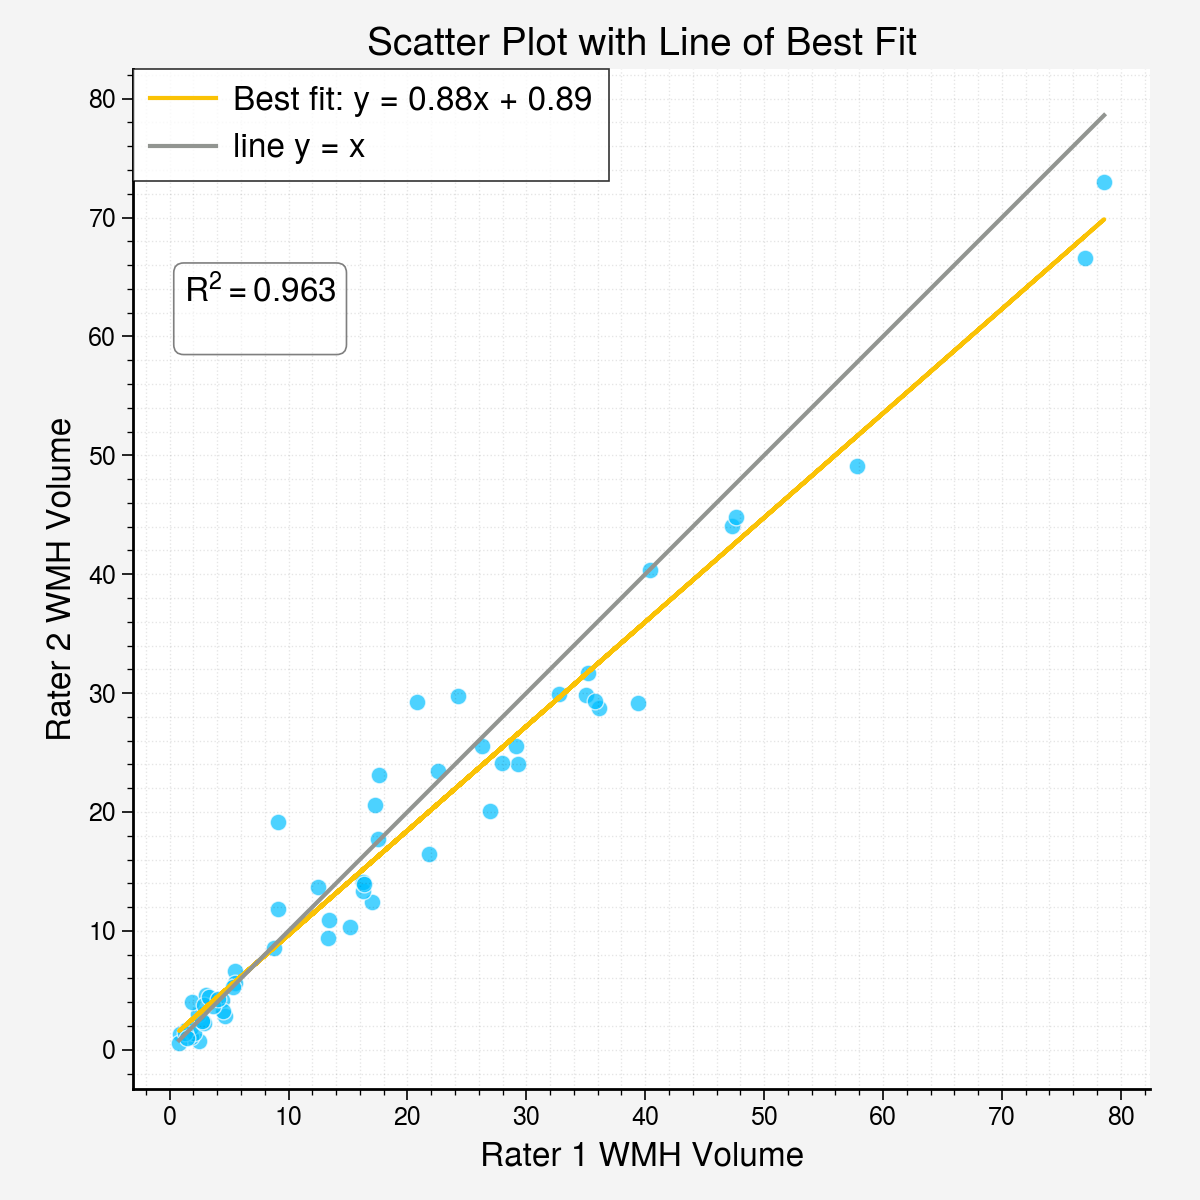

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Example data
x = df["WMH1_mm3"]
y = df["WMH2_mm3"]

# Calculate line of best fit
slope, intercept, r_value, p_value, std_err = linregress(x, y)
line = slope * x + intercept

# Create scatter plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x, y, color='deepskyblue', alpha=0.7, edgecolors='w', linewidth=0.5)

# Plot line of best fit
plt.plot(x.values, line.values, color='goldenrod', label=f'Best fit: y = {slope:.2f}x + {intercept:.2}')
plt.plot([min(x), max(x)], [min(x), max(x)], color='gray', label=f'line y = x')

# Annotate with text (R^2 and line equation)
plt.text(0.05, 0.80, f'$R^2 = {r_value**2:.3f}$\n', transform=plt.gca().transAxes,
         fontsize=12,  verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Enhance aesthetics
plt.title('Scatter Plot with Line of Best Fit', fontsize=14, )
plt.xlabel('Rater 1 WMH Volume', fontsize=12, )
plt.ylabel('Rater 2 WMH Volume', fontsize=12, )
plt.legend(fontsize=12)

plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.minorticks_on()


# Remove right and top spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Make left and bottom spines thicker
ax.spines['left'].set_linewidth(1.)
ax.spines['bottom'].set_linewidth(1.)

ax.set_aspect('equal', adjustable='box')

plt.tight_layout()    

# Show plot
plt.show()


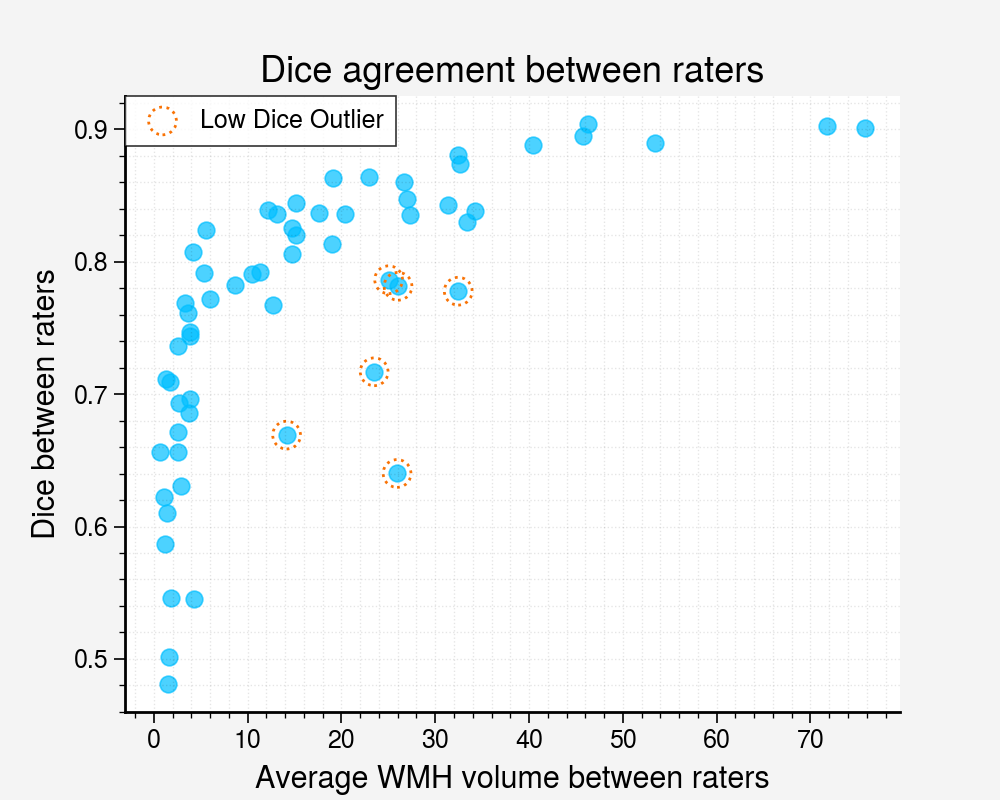

In [30]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(5, 4))
y = df["DSC"]
x = (df["WMH1_mm3"] + df["WMH2_mm3"]) / 2
ax.scatter(x, y, alpha=0.7, c='deepskyblue')

# annotation
plt.title("Dice agreement between raters", fontsize=13)
plt.xlabel("Average WMH volume between raters", fontsize=11)
plt.ylabel("Dice between raters", fontsize=11)

# grid
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.minorticks_on()

# point out influential outliers
xps = []
yps = []
for (xi, yi) in zip(x, y):
    if (xi > 10 and yi < 0.7) or (xi > 20 and yi < 0.8):
        xps.append(xi)
        yps.append(yi)
scatter = ax.scatter(xps, yps, facecolors='none', edgecolors='orange', linewidth=1, s=100, linestyle=':', label='Low Dice Outlier')
plt.legend()

# Remove right and top spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# # Make left and bottom spines thicker
ax.spines['left'].set_linewidth(1.)
ax.spines['bottom'].set_linewidth(1.)

# plt.tight_layout()

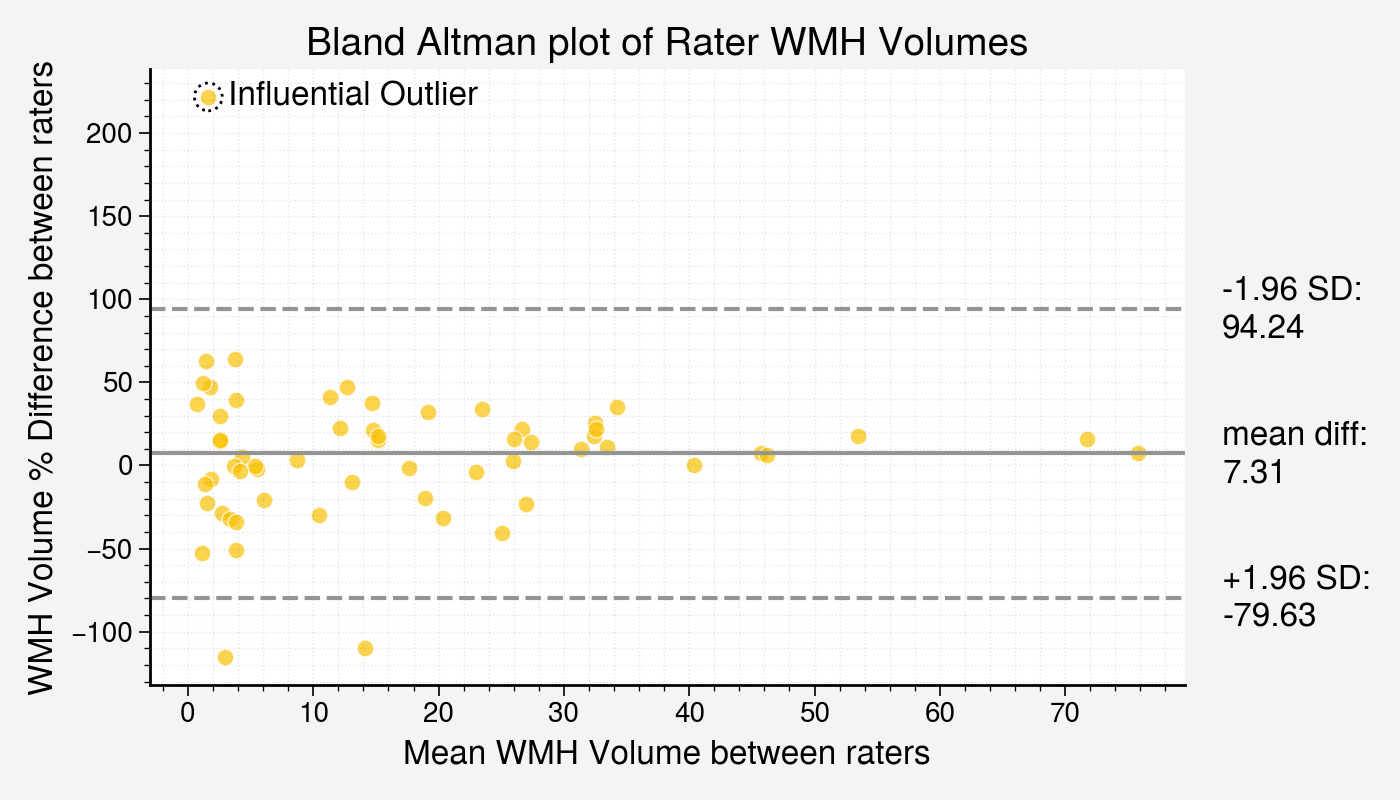

In [35]:
x = df["WMH1_mm3"]
y = df["WMH2_mm3"]
z = df["WMH3_mm3"]
# mean = (x + y + z) / 3
# diff = np.maximum((x - mean), np.maximum((y - mean), (z-mean)))
# percent_diff = 100 * diff / mean # np.minimum(x, np.minimum(y, z))
mean = (x + y) / 2
diff = (x - y)
percent_diff = 100 * diff / np.minimum(x, y)
mean_percent_diff = np.mean(percent_diff)

std = np.std(percent_diff, ddof=1)
conf_bound_95 = 1.96 * std

fontsize = 12

fig, ax = plt.subplots(figsize=(7, 4))
ax.scatter(mean, percent_diff, color='goldenrod', alpha=0.7, edgecolors='w', linewidth=0.5)

# mean and 95% confidence lines
ax.axhline(y=mean_percent_diff, color='gray')
rhs_point = max(x) * 1.05
ax.text(rhs_point, mean_percent_diff + 1, 'mean diff:', verticalalignment='bottom', horizontalalignment='left', fontsize=fontsize)
ax.text(rhs_point, mean_percent_diff - 3, f'{mean_percent_diff:.2f}', verticalalignment='top', horizontalalignment='left', fontsize=fontsize)
ax.axhline(y=mean_percent_diff - conf_bound_95, color='gray', linestyle='--')
ax.text(rhs_point, mean_percent_diff - conf_bound_95 + 1, '+1.96 SD:', verticalalignment='bottom', horizontalalignment='left', fontsize=fontsize)
ax.text(rhs_point, mean_percent_diff - conf_bound_95 - 3, f'{mean_percent_diff - conf_bound_95:.2f}', verticalalignment='top', horizontalalignment='left', fontsize=fontsize)
ax.axhline(y=mean_percent_diff + conf_bound_95, color='gray', linestyle='--')
ax.text(rhs_point, mean_percent_diff + conf_bound_95 + 1, '-1.96 SD:', verticalalignment='bottom', horizontalalignment='left', fontsize=fontsize)
ax.text(rhs_point, mean_percent_diff + conf_bound_95 - 3, f'{mean_percent_diff + conf_bound_95:.2f}', verticalalignment='top', horizontalalignment='left', fontsize=fontsize)

# point out influential outliers
outlier_sd = 3
for (m, pd) in zip(mean, percent_diff):
    if pd > mean_percent_diff + (3 * std) or pd < mean_percent_diff - (3 * std):
        scatter = ax.scatter(m, pd, facecolors='none', edgecolors='black', linewidth=1, s=100, linestyle=':')
        ax.text(m + max(x) * 0.02, pd, 'Influential Outlier', verticalalignment='center', horizontalalignment='left', fontsize=fontsize)

# spines and ticks
ax = plt.gca() # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.)
ax.spines['bottom'].set_linewidth(1.)
plt.minorticks_on()
ax.tick_params(axis='both', labelsize=fontsize-2)

# legend
# plt.legend(fontsize=12)

# grid
plt.grid(True, which='both', linestyle=':', linewidth=0.5)


plt.title("Bland Altman plot of Rater WMH Volumes", fontsize=fontsize+2)
plt.ylabel("WMH Volume % Difference between raters", fontsize=fontsize)
plt.xlabel("Mean WMH Volume between raters", fontsize=fontsize)

plt.tight_layout()

### Note to self, I need to think again and be careful about these bland altman plots and check whether I have implemented them correctly, secifically in the multi-rater case